# **Classifying Clothing Images**

In [1]:
# Import the necessary libraries
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
# Loading the Fashion-MNIST dataset
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

100%|██████████| 26421880/26421880 [00:01<00:00, 16481434.60it/s]


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 296597.81it/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5545886.34it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17399095.08it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



In [3]:
# Examine a sample
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


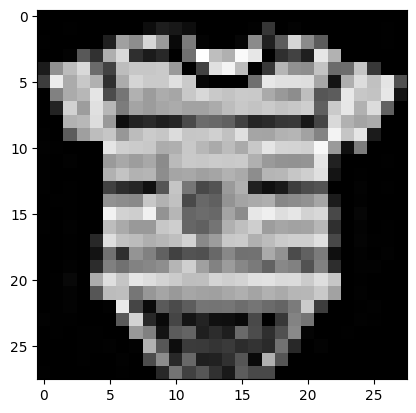

In [4]:
plt.imshow(images[1].numpy().squeeze(), cmap = 'Greys_r')

In [5]:
# Define the network architecture
from torch import nn, optim
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available! Using GPU for computations.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU for computations.")
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(4, 16, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 24, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(24, 24, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Linear(864, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes),
        )
        self.log_softmax = nn.LogSoftmax(dim = 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        x = self.log_softmax(x)
        return x

model = AlexNet(10)
# summary(model, (1,28,28))
model.to(device)
# Define the loss
criterion = nn.NLLLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.002)

def label_smoothing(act, pred):
  return -1*(torch.sum(act*pred)/act.shape[0])

# Define the epochs
epochs = 30

train_losses, test_losses = [], []
to_print = True
for e in range(epochs):
  running_loss = 0
  for images, labels in tqdm(trainloader, desc ="Training"):

    optimizer.zero_grad()
    labels = labels.to(device)
    images = images.to(device)
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0

    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
      # Set the model to evaluation mode
      model.eval()

      # Validation pass
      for images, labels in testloader:

        labels = labels.to(device)
        images = images.to(device)
        log_ps = model(images)

        test_loss += criterion(log_ps, labels)

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

CUDA is not available. Using CPU for computations.


Training: 100%|██████████| 938/938 [00:49<00:00, 18.82it/s]


Epoch: 1/30.. Training loss: 0.661.. Test loss: 0.440.. Test Accuracy: 0.835


Training: 100%|██████████| 938/938 [00:49<00:00, 19.03it/s]


Epoch: 2/30.. Training loss: 0.405.. Test loss: 0.372.. Test Accuracy: 0.865


Training: 100%|██████████| 938/938 [00:49<00:00, 18.87it/s]


Epoch: 3/30.. Training loss: 0.349.. Test loss: 0.355.. Test Accuracy: 0.868


Training: 100%|██████████| 938/938 [00:48<00:00, 19.44it/s]


Epoch: 4/30.. Training loss: 0.320.. Test loss: 0.351.. Test Accuracy: 0.874


Training: 100%|██████████| 938/938 [00:49<00:00, 19.13it/s]


Epoch: 5/30.. Training loss: 0.301.. Test loss: 0.319.. Test Accuracy: 0.884


Training: 100%|██████████| 938/938 [00:48<00:00, 19.47it/s]


Epoch: 6/30.. Training loss: 0.289.. Test loss: 0.330.. Test Accuracy: 0.883


Training: 100%|██████████| 938/938 [00:48<00:00, 19.41it/s]


Epoch: 7/30.. Training loss: 0.279.. Test loss: 0.320.. Test Accuracy: 0.891


Training: 100%|██████████| 938/938 [00:48<00:00, 19.37it/s]


Epoch: 8/30.. Training loss: 0.269.. Test loss: 0.313.. Test Accuracy: 0.889


Training: 100%|██████████| 938/938 [00:47<00:00, 19.58it/s]


Epoch: 9/30.. Training loss: 0.261.. Test loss: 0.304.. Test Accuracy: 0.896


Training: 100%|██████████| 938/938 [00:52<00:00, 17.93it/s]


Epoch: 10/30.. Training loss: 0.257.. Test loss: 0.296.. Test Accuracy: 0.894


Training: 100%|██████████| 938/938 [00:47<00:00, 19.75it/s]


Epoch: 11/30.. Training loss: 0.251.. Test loss: 0.312.. Test Accuracy: 0.889


Training: 100%|██████████| 938/938 [00:47<00:00, 19.74it/s]


Epoch: 12/30.. Training loss: 0.246.. Test loss: 0.293.. Test Accuracy: 0.893


Training: 100%|██████████| 938/938 [00:47<00:00, 19.75it/s]


Epoch: 13/30.. Training loss: 0.244.. Test loss: 0.308.. Test Accuracy: 0.889


Training: 100%|██████████| 938/938 [00:47<00:00, 19.76it/s]


Epoch: 14/30.. Training loss: 0.236.. Test loss: 0.284.. Test Accuracy: 0.895


Training: 100%|██████████| 938/938 [00:48<00:00, 19.18it/s]


Epoch: 15/30.. Training loss: 0.235.. Test loss: 0.290.. Test Accuracy: 0.900


Training: 100%|██████████| 938/938 [00:48<00:00, 19.29it/s]


Epoch: 16/30.. Training loss: 0.232.. Test loss: 0.301.. Test Accuracy: 0.898


Training: 100%|██████████| 938/938 [00:49<00:00, 19.02it/s]


Epoch: 17/30.. Training loss: 0.228.. Test loss: 0.294.. Test Accuracy: 0.896


Training: 100%|██████████| 938/938 [00:48<00:00, 19.35it/s]


Epoch: 18/30.. Training loss: 0.221.. Test loss: 0.300.. Test Accuracy: 0.896


Training: 100%|██████████| 938/938 [00:50<00:00, 18.64it/s]


Epoch: 19/30.. Training loss: 0.223.. Test loss: 0.300.. Test Accuracy: 0.896


Training: 100%|██████████| 938/938 [00:48<00:00, 19.42it/s]


Epoch: 20/30.. Training loss: 0.226.. Test loss: 0.309.. Test Accuracy: 0.895


Training: 100%|██████████| 938/938 [00:48<00:00, 19.43it/s]


Epoch: 21/30.. Training loss: 0.219.. Test loss: 0.308.. Test Accuracy: 0.900


Training: 100%|██████████| 938/938 [00:48<00:00, 19.28it/s]


Epoch: 22/30.. Training loss: 0.215.. Test loss: 0.291.. Test Accuracy: 0.903


Training: 100%|██████████| 938/938 [00:48<00:00, 19.40it/s]


Epoch: 23/30.. Training loss: 0.212.. Test loss: 0.310.. Test Accuracy: 0.899


Training: 100%|██████████| 938/938 [00:49<00:00, 18.86it/s]


Epoch: 24/30.. Training loss: 0.211.. Test loss: 0.297.. Test Accuracy: 0.898


Training: 100%|██████████| 938/938 [00:47<00:00, 19.63it/s]


Epoch: 25/30.. Training loss: 0.209.. Test loss: 0.292.. Test Accuracy: 0.899


Training: 100%|██████████| 938/938 [00:48<00:00, 19.51it/s]


Epoch: 26/30.. Training loss: 0.206.. Test loss: 0.310.. Test Accuracy: 0.899


Training: 100%|██████████| 938/938 [00:48<00:00, 19.22it/s]


Epoch: 27/30.. Training loss: 0.203.. Test loss: 0.309.. Test Accuracy: 0.896


Training: 100%|██████████| 938/938 [00:49<00:00, 19.00it/s]


Epoch: 28/30.. Training loss: 0.206.. Test loss: 0.321.. Test Accuracy: 0.894


Training: 100%|██████████| 938/938 [00:50<00:00, 18.73it/s]


Epoch: 29/30.. Training loss: 0.198.. Test loss: 0.304.. Test Accuracy: 0.898


Training: 100%|██████████| 938/938 [00:49<00:00, 18.96it/s]


Epoch: 30/30.. Training loss: 0.198.. Test loss: 0.308.. Test Accuracy: 0.903


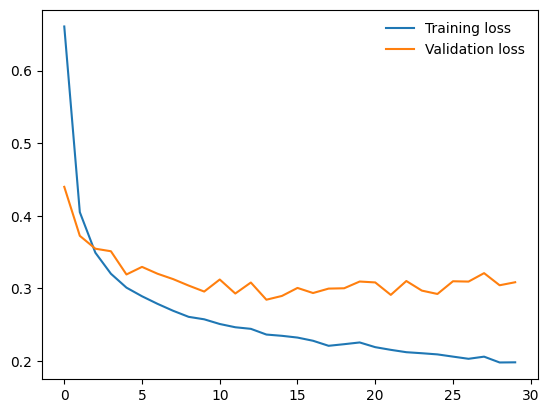

In [6]:
plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.legend(frameon = False)